<a href="https://www.kaggle.com/code/dfbaf77/uk-electricity-consumption?scriptVersionId=201395678" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Challenge Problem

* Cleans it as necessary and presents the data. Charts should also show a moving average overlay.
* As well as presenting the overall dataset, you should provide summaries of the data. The summary data should be constructed by you from the data presented - you might think of reading the data into an in-memory database, such as sqllite, and computing the summaries there.
* Summaries should include year-on-year averages, **daily/weekly/yearly** peak and trough demand
* As an additional bonus, consider adding annotations indicating **“interesting”** features of the dataset.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualisation
import matplotlib.pyplot as plt # data visualisation

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/uk-power-consumption/gridwatch.csv


# BigPay Data Engineer Challenge: Table of Contents

- ## [1. Understanding the Dataset](#1-Understanding-the-Dataset)
  - [1.1 Dataset Overview](#11-Dataset-Overview)
  - [1.2 Key Columns](#12-Key-Columns)
  - [1.3 Source Contribution Columns](#13-Source-Contribution-Columns)

- ## [2. Pre-processing](#2-Preprocessing)
  - [2.1 Loading the Dataset](#21-Loading-the-Dataset)
  - [2.2 Triming Column Header](#22-Triming-Column-Header)
  - [2.3 Handling Missing Value](#23-Handling-Missing-Value)
  
- ## [3. EDA](#3-EDA)
  - [3.1 Generating Time-Based Aggregations (Daily/Weekly/Yearly)](#31-Generating-Time-Based-Aggregations-(Daily/Weekly/Yearly))      
  - [3.2 Calculating Daily/Weekly/Year Averages](#32-Calculating-Averages)

- ## [4. Data Visualization](#4-Data-Visualization)
  - [4.1 Daily, Weekly, and Yearly Aggregates](#41-DailyWeeklyYearly-Aggregates)
  - [4.2 Peak and Trough Demand (Daily/Weekly/Yearly)](#42-Peak-and-Trough-Demand)
  - [4.3 Implementing Moving Averages](#43-Implementing-Moving-Averages)
  - [4.4 Interactive Charts and Filters](#44-Interactive-Charts-and-Filters)
    - [4.4.1 Time-based Filtering (Day, Week, Year)](#441-Time-based-Filtering-Day-Week-Year)
    - [4.4.2 Source-based Filtering (Specific power sources)](#442-Source-based-Filtering-Specific-power-sources)
    
- ## [5. Summary Reports and Insights](#5-Summary-Reports-and-Insights)
  - [5.1 Analyzing the Daily, Weekly, and Yearly Aggregates Graph](#51-Analyzing)
  - [5.2 Analyzing the Time Series Plots](#52-Analyzing-Time-Series-Plots)
  - [5.3 Analyzing the Correlation Matrix](#53-Analyzing-Correlation-Matrix)
  - [5.4 Analyzing the Bar Charts](#54-Analyzing-the-Bar-Charts)
  - [5.5 Analyzing the Daily Moving Average Graph](#55-Analyzing-the-Daily-Moving-Average-Graph)


<a id="1-Understanding-the-Dataset"></a>
## 1. Understanding the Dataset

<a id="11-Dataset-Overview"></a>
### 1.1 Dataset Overview
* Gridwatch (https://www.gridwatch.templar.co.uk/) provides a dataset of historical UK power consumption since 2011.

<a id="112-Key-Columns"></a>
### 1.2 Key Columns
* The dataset consists of 23 columns:
    - Four primary columns:
        - ID : "id"
        - Record timestamp : "timestamp"
        - Recorded demand : "demand"
        - Current frequency : "frequency"

<a id="13-Source-Contribution-Columns"></a>
### 1.3 Source Contribution Columns
* 19 columns indicating the amount contributed by each source.

<a id="2-Preprocessing"></a>
## 2. Pre-processing

<a id="21-Loading-the-Dataset"></a>
### 2.1 Loading the Dataset
- The raw file is provided in csv file
- We will use pandas to load the data into a DataFrame

In [2]:
# Loading datasets into dataframe
rawfile = '/kaggle/input/uk-power-consumption/gridwatch.csv'
df = pd.read_csv(rawfile,
                parse_dates=[' timestamp'],
                index_col=' timestamp')

# Show first 5 rows
df.head()

,id,demand,frequency,coal,nuclear,ccgt,wind,pumped,hydro,biomass,...,irish_ict,ew_ict,nemo,other,north_south,scotland_england,ifa2,intelec_ict,nsl,vkl_ict
timestamp,,,,,,,,,,,,,,,,,,,,,
2011-05-27 15:50:04,4,38874,50.132000,9316,8221,18239,1253,309,636,0,...,-414,0.0,0,0,0,0,0,0,0,0
2011-05-27 15:55:02,5,38845,50.091000,9294,8225,18158,1304,332,633,0,...,-414,0.0,0,0,0,0,0,0,0,0
2011-05-27 16:00:02,6,38745,50.034000,9270,8224,18110,1322,285,634,0,...,-414,0.0,0,0,0,0,0,0,0,0
2011-05-27 16:05:01,7,38826,49.990002,9262,8220,18114,1364,287,635,0,...,-414,0.0,0,0,0,0,0,0,0,0
2011-05-27 16:10:02,8,38865,50.016998,9256,8210,18107,1370,297,637,0,...,-414,0.0,0,0,0,0,0,0,0,0


<a id="22-Triming-Column-Header"></a>
### 2.2 Triming Column Header
- There are spacing in columns header, will trim the spaces for all columns header

In [3]:
# Showing list of columns in datasets
print('Old Columns:-')
print(df.columns,'\n')

Old Columns:-
Index(['id', ' demand', ' frequency', ' coal', ' nuclear', ' ccgt', ' wind',
       ' pumped', ' hydro', ' biomass', ' oil', ' solar', ' ocgt',
       ' french_ict', ' dutch_ict', ' irish_ict', ' ew_ict', ' nemo', ' other',
       ' north_south', ' scotland_england', ' ifa2', ' intelec_ict', ' nsl',
       ' vkl_ict'],
      dtype='object') 



In [4]:
# Trimming spaces in header
corrected_columns = [column.strip() for column in df.columns]
df.columns = corrected_columns
print('New Columns:-')
print(df.columns)

New Columns:-
Index(['id', 'demand', 'frequency', 'coal', 'nuclear', 'ccgt', 'wind',
       'pumped', 'hydro', 'biomass', 'oil', 'solar', 'ocgt', 'french_ict',
       'dutch_ict', 'irish_ict', 'ew_ict', 'nemo', 'other', 'north_south',
       'scotland_england', 'ifa2', 'intelec_ict', 'nsl', 'vkl_ict'],
      dtype='object')


<a id="23-Handling-Missing-Value"></a>
### 2.3 Handling Missing Value
- Checking if the data have missing value

In [5]:
# There is no missing value
df.isna().sum()

id                  0
demand              0
frequency           0
coal                0
nuclear             0
ccgt                0
wind                0
pumped              0
hydro               0
biomass             0
oil                 0
solar               0
ocgt                0
french_ict          0
dutch_ict           0
irish_ict           0
ew_ict              0
nemo                0
other               0
north_south         0
scotland_england    0
ifa2                0
intelec_ict         0
nsl                 0
vkl_ict             0
dtype: int64

<a id="3-EDA"></a>
## 3. EDA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1403533 entries, 2011-05-27 15:50:04 to 2024-10-08 06:55:32
Data columns (total 25 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1403533 non-null  int64  
 1   demand            1403533 non-null  int64  
 2   frequency         1403533 non-null  float64
 3   coal              1403533 non-null  int64  
 4   nuclear           1403533 non-null  int64  
 5   ccgt              1403533 non-null  int64  
 6   wind              1403533 non-null  int64  
 7   pumped            1403533 non-null  int64  
 8   hydro             1403533 non-null  int64  
 9   biomass           1403533 non-null  int64  
 10  oil               1403533 non-null  int64  
 11  solar             1403533 non-null  float64
 12  ocgt              1403533 non-null  int64  
 13  french_ict        1403533 non-null  int64  
 14  dutch_ict         1403533 non-null  float64
 15  irish_ict       

In [7]:
df.describe()

,id,demand,frequency,coal,nuclear,ccgt,wind,pumped,hydro,biomass,...,irish_ict,ew_ict,nemo,other,north_south,scotland_england,ifa2,intelec_ict,nsl,vkl_ict
count,1.403533e+06,1.403533e+06,1.403533e+06,1.403533e+06,1.403533e+06,1.403533e+06,1.403533e+06,1.403533e+06,1.403533e+06,1.403533e+06,...,1.403533e+06,1.403533e+06,1.403533e+06,1.403533e+06,1.403533e+06,1.403533e+06,1.403533e+06,1.403533e+06,1.403533e+06,1.403533e+06
mean,7.017709e+05,3.176838e+04,4.991423e+01,4.953981e+03,6.332801e+03,1.137573e+04,4.277617e+03,2.626150e+02,4.067420e+02,1.410784e+03,...,-1.018601e+02,-4.724293e+30,1.988356e+02,1.059750e+02,1.132143e+03,9.126618e+02,6.468479e+01,5.184099e+01,1.750949e+02,2.589329e+01
std,4.051654e+05,7.112681e+03,2.088593e+00,6.178986e+03,1.413117e+03,5.329941e+03,3.546667e+03,3.527518e+02,2.495238e+02,8.560693e+02,...,2.334560e+02,2.479333e+33,4.442084e+02,1.686569e+02,1.814151e+03,1.408573e+03,3.835483e+02,3.294340e+02,4.702781e+02,1.795125e+02
min,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-9.040000e+02,-1.313282e+36,-1.024000e+03,0.000000e+00,-4.498000e+03,-2.882000e+03,-1.030000e+03,-1.028000e+03,-1.454000e+03,-1.454000e+03
25%,3.508880e+05,2.614900e+04,4.995600e+01,2.290000e+02,5.157000e+03,6.983000e+03,1.498000e+03,0.000000e+00,2.000000e+02,7.490000e+02,...,-2.540000e+02,-2.600000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.017710e+05,3.091600e+04,4.999900e+01,1.362000e+03,6.493000e+03,1.121500e+04,3.214000e+03,1.360000e+02,3.740000e+02,1.409000e+03,...,-1.040000e+02,0.000000e+00,0.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.052654e+06,3.671900e+04,5.004500e+01,9.220000e+03,7.491000e+03,1.530000e+04,6.088000e+03,3.930000e+02,5.790000e+02,2.074000e+03,...,7.400000e+01,3.600000e+01,5.800000e+02,1.500000e+02,2.230000e+03,1.719000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.403537e+06,2.548520e+05,5.040300e+01,2.530000e+04,9.346000e+03,2.716300e+04,1.748500e+04,2.861000e+03,1.462000e+03,4.017000e+03,...,6.870000e+02,5.710000e+02,1.769000e+03,9.168000e+03,1.054000e+04,6.420000e+03,1.037000e+03,1.014000e+03,1.846000e+03,1.426000e+03


<a id="31-Generating-Time-Based-Aggregations-(Daily/Weekly/Yearly)"></a>
### 3.1 Generating Time-Based Aggregations (Daily/Weekly/Yearly)

In [8]:
# Resample the data
daily_data = df.resample('D').mean()  # Daily aggregation
weekly_data = df.resample('W').mean() # Weekly aggregation
yearly_data = df.resample('Y').mean() # Yearly aggregation

# Add a column to identify the frequency
daily_data['rate'] = 'Daily'
weekly_data['rate'] = 'Weekly'
yearly_data['rate'] = 'Yearly'

<a id="32-Calculating-Averages"></a>
### 3.2 Calculating Daily/Weekly/Yearly Averages

In [9]:
print("Daily Average")
display(daily_data.head())
print()

print("Weekly Average")
display(weekly_data.head())
print()

print("Yearly Average")
display(yearly_data.head())

Daily Average


,id,demand,frequency,coal,nuclear,ccgt,wind,pumped,hydro,biomass,...,ew_ict,nemo,other,north_south,scotland_england,ifa2,intelec_ict,nsl,vkl_ict,rate
timestamp,,,,,,,,,,,,,,,,,,,,,
2011-05-27,52.5,34138.163265,50.022531,7218.795918,8286.214286,15106.489796,1840.459184,230.408163,543.867347,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Daily
2011-05-28,245.0,30304.543554,50.007972,6394.383275,8465.933798,11286.466899,2141.268293,277.066202,503.313589,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Daily
2011-05-29,532.5,29053.767361,49.997563,4738.454861,8754.180556,11385.517361,2029.381944,242.451389,512.392361,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Daily
2011-05-30,820.0,31449.069686,49.994352,6864.822300,8815.519164,13948.090592,532.843206,356.585366,583.540070,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Daily
2011-05-31,1107.0,34366.334495,50.000850,8849.498258,8302.264808,15253.452962,700.177700,328.954704,483.905923,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Daily



Weekly Average


,id,demand,frequency,coal,nuclear,ccgt,wind,pumped,hydro,biomass,...,ew_ict,nemo,other,north_south,scotland_england,ifa2,intelec_ict,nsl,vkl_ict,rate
timestamp,,,,,,,,,,,,,,,,,,,,,
2011-05-29,340.0,30327.531947,50.005637,5805.802377,8563.114413,11885.112927,2049.585438,255.459138,513.104012,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Weekly
2011-06-05,1680.0,32774.273044,49.999924,7581.909816,8541.879422,13900.878426,906.350772,329.617838,454.972098,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Weekly
2011-06-12,3691.5,33799.846726,50.000410,9161.726190,8243.776786,14126.389881,550.308036,303.682044,334.338294,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Weekly
2011-06-19,5707.0,33466.395533,49.999545,8836.754839,7958.303226,14181.388586,812.687345,283.339950,277.122581,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Weekly
2011-06-26,7722.0,33639.015881,49.999149,8924.415881,7928.251117,13876.397519,698.160794,295.120596,282.173697,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Weekly



Yearly Average


,id,demand,frequency,coal,nuclear,ccgt,wind,pumped,hydro,biomass,...,ew_ict,nemo,other,north_south,scotland_england,ifa2,intelec_ict,nsl,vkl_ict,rate
timestamp,,,,,,,,,,,,,,,,,,,,,
2011-12-31,31348.500000,35117.011533,49.973152,11243.906907,6734.439815,14000.322492,1219.795135,332.148205,466.658941,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,Yearly
2012-12-31,115321.270562,36554.332260,49.993865,15630.434915,7514.328127,9455.295672,1435.485117,331.801112,372.808940,237.981436,...,-9.746273,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,Yearly
2013-12-31,220313.500000,36247.977351,49.999951,14355.798134,7526.513864,9135.930888,2127.126709,320.079883,332.950624,439.390879,...,-247.851826,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,Yearly
2014-12-31,325101.000000,34421.810161,49.845724,11025.881341,6821.166719,9876.204078,2416.926159,318.751476,447.842094,852.327038,...,-275.139756,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,Yearly
2015-12-31,429962.000000,33028.107509,49.967928,8506.284996,7501.486303,9630.220892,2670.218641,306.413244,467.429302,1288.407380,...,-121.517559,0.0,0.0,14.169459,9.160353,0.0,0.0,0.0,0.0,Yearly


<a id="33-Identifying-Peaks-and-Troughs-Max-Min-Demand"></a>
### 3.3 Identifying Daily/Weekly/Yearly Peaks and Troughs (Max/Min Demand)

In [10]:
from scipy.signal import find_peaks
def find_peak_trough(title,dataused):
    # Find peaks
    peaks, _ = find_peaks(dataused['demand'])
    # Find troughs
    troughs, _ = find_peaks(~dataused['demand'].astype(int))
    
    # Mark peaks
    max_value = dataused['demand'][peaks].max()
    max_filtered = dataused['demand'][peaks][dataused['demand'][peaks] == max_value]
    
    # Mark troughs
    min_value = dataused['demand'][troughs].min()
    min_filtered = dataused['demand'][troughs][dataused['demand'][troughs] == min_value]
    
    print(title)
    return print(max_filtered), print(min_filtered)
    
find_peak_trough('Daily Peak & Trough',daily_data)
print()

find_peak_trough('Weekly Peak & Trough',weekly_data)
print()

find_peak_trough('Yearly Peak & Trough',yearly_data)
print()    
    


Daily Peak & Trough
 timestamp
2012-02-08    49793.423611
Name: demand, dtype: float64
 timestamp
2020-05-31    19518.163194
Name: demand, dtype: float64

Weekly Peak & Trough
 timestamp
2012-02-12    47122.945933
Name: demand, dtype: float64
 timestamp
2020-05-31    21560.313988
Name: demand, dtype: float64

Yearly Peak & Trough
 timestamp
2012-12-31    36554.33226
Freq: 10YE-DEC, Name: demand, dtype: float64
 timestamp
2020-12-31    28446.287559
Freq: YE-DEC, Name: demand, dtype: float64



<a id="4-Data-Visualization"></a>
## 4. Data Visualization

<a id="41-DailyWeeklyYearly-Aggregates"></a>
### 4.1 Daily, Weekly, and Yearly Aggregates

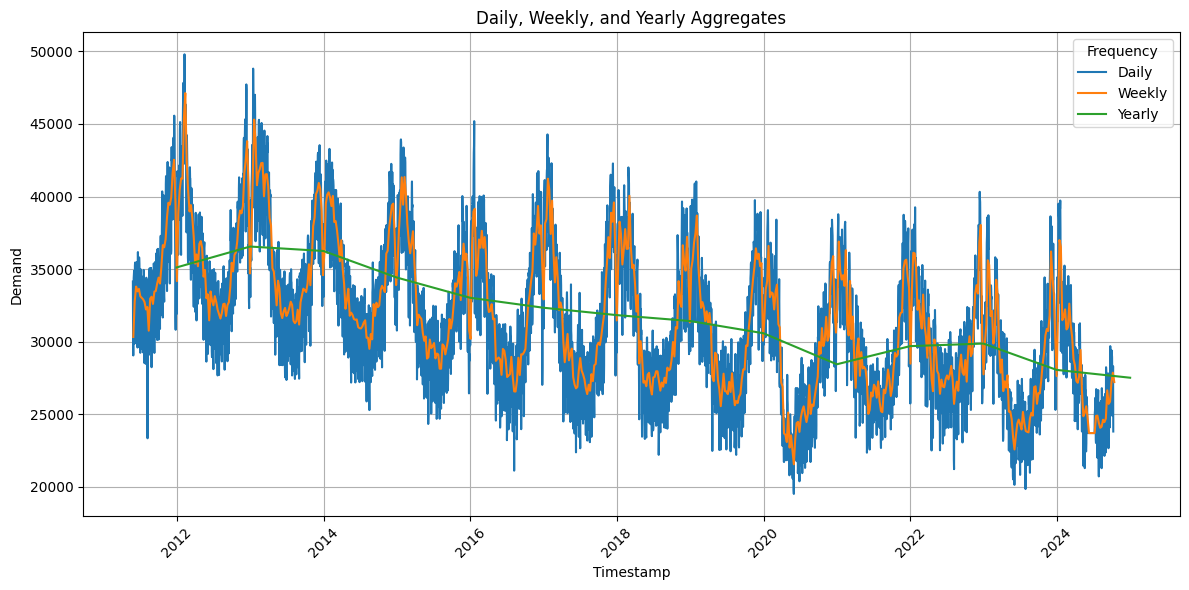

In [11]:
# Concatenating resample data
aggregated = pd.concat([daily_data, weekly_data, yearly_data])

# Size of graph
plt.figure(figsize=(12, 6))

# Create the line plot
sns.lineplot(data=aggregated, x=aggregated.index, y='demand', hue='rate')

# Customize the plot
plt.title('Daily, Weekly, and Yearly Aggregates')
plt.xlabel('Timestamp')
plt.ylabel('Demand')
plt.xticks(rotation=45)
plt.legend(title='Frequency')
plt.tight_layout()


# Adding grid
plt.grid(True)

# Show the plot
plt.show()


<a id="42-Peak-and-Trough-Demand"></a>
### 4.2 Peak and Trough Demand (Daily/Weekly/Yearly)

<Figure size 640x480 with 0 Axes>

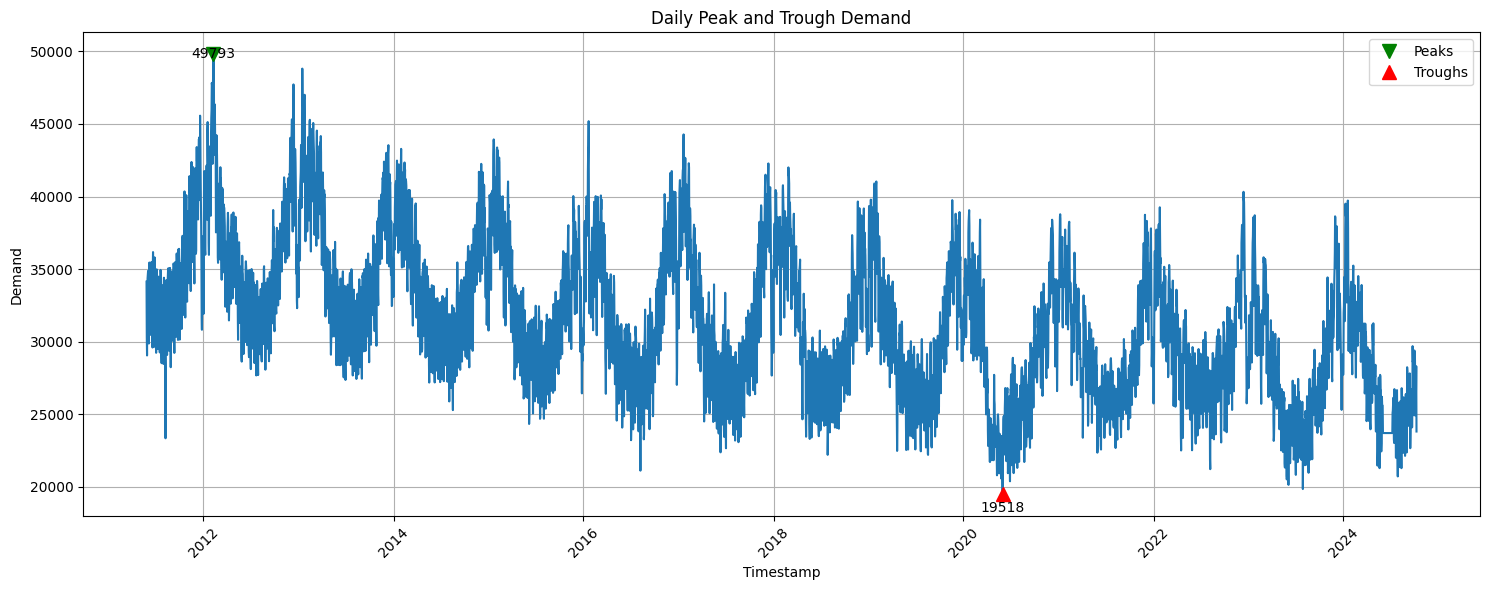

<Figure size 640x480 with 0 Axes>

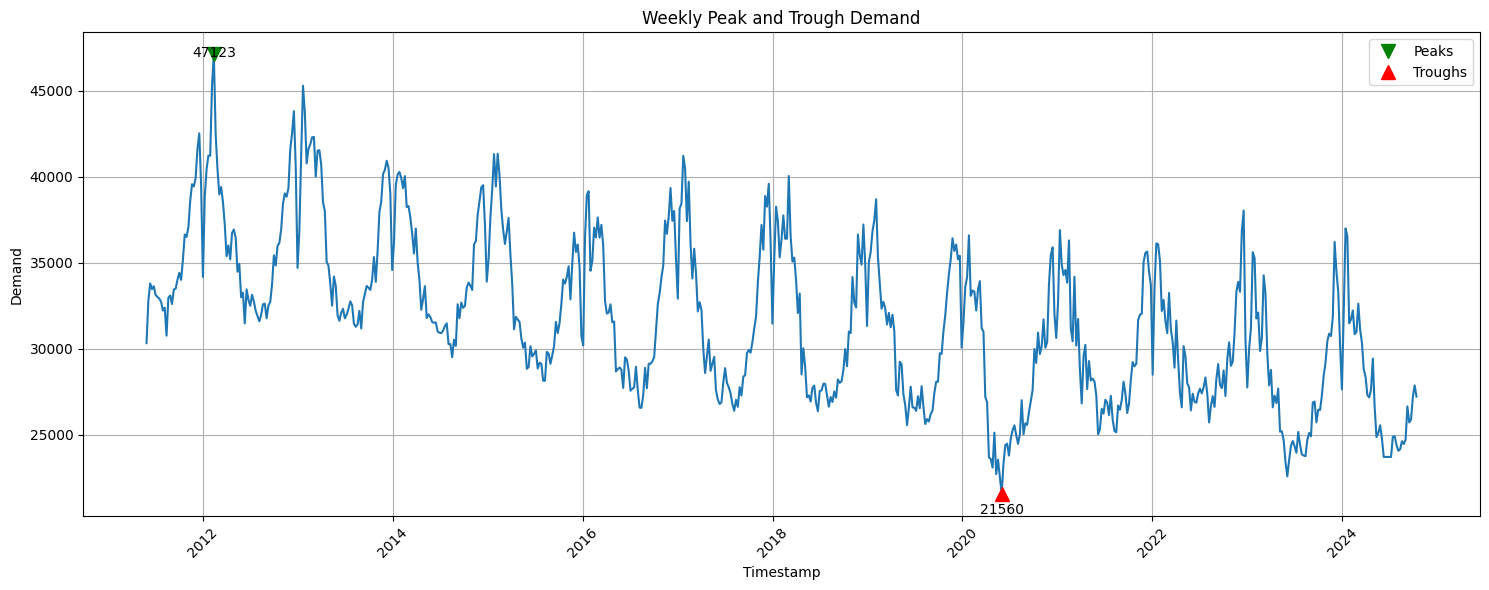

<Figure size 640x480 with 0 Axes>

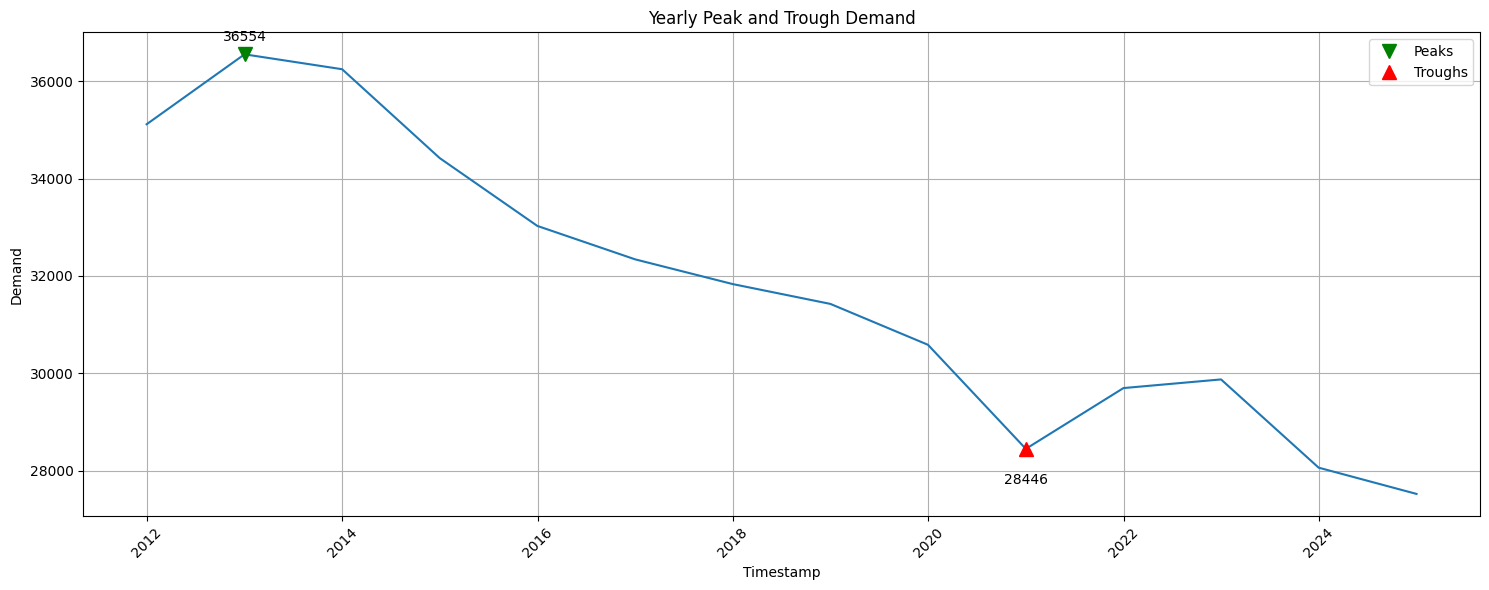

In [12]:
def detecting_peak_trough(title, dataused):
    # Clear the current figure
    plt.clf()
    
    # Size of graph
    plt.figure(figsize=(15, 6))
    

    # Create the line plot
    sns.lineplot(data=dataused, 
                 x=dataused.index,
                 y='demand',
                 # color='green',
                 # marker="o"
                )
    
    # Find peaks
    peaks, _ = find_peaks(dataused['demand'])
    
    # Find troughs (invert the data to find troughs as peaks)
    troughs, _ = find_peaks(~dataused['demand'].astype(int))
    
    # Mark peaks
    max_value = dataused['demand'][peaks].max()
    max_filtered = dataused['demand'][peaks][dataused['demand'][peaks] == max_value]
    plt.plot(max_filtered.index, max_value, "v", label="Peaks", markersize=10, color='green')
    
    # Mark troughs
    min_value = dataused['demand'][troughs].min()
    min_filtered = dataused['demand'][troughs][dataused['demand'][troughs] == min_value]
    plt.plot(min_filtered.index, min_value, "^", label="Troughs", markersize=10, color='red')
    
    # Annotate the peaks
    plt.text(max_filtered.index, max_value+500, 
             f'{max_value:.0f}',
             color='black',
             ha='center',
             va='top')
    
    # Annotate the troughs
    plt.text(min_filtered.index, min_value-500, 
             f'{min_value:.0f}',
             color='black',
             ha='center',
             va='top')
        
    # Customize the plot
    plt.title(title)
    plt.xlabel('Timestamp')
    plt.ylabel('Demand')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    
    # Adding grid
    plt.grid(True)
    
    
    # Show the plot
    plt.show()

    

detecting_peak_trough('Daily Peak and Trough Demand', daily_data)

detecting_peak_trough('Weekly Peak and Trough Demand', weekly_data)

detecting_peak_trough('Yearly Peak and Trough Demand', yearly_data)

<a id="43-Peak-and-Trough-Demand"></a>
### 4.2 Peak and Trough Demand (Daily/Weekly/Yearly)

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

def interactive_MA(title,dataused):
    # Function to plot the moving average with an adjustable window
    def plot_moving_average(window_size):
        dataused['Moving Average'] = dataused['demand'].rolling(window=window_size).mean()

        plt.figure(figsize=(20, 6))
        plt.plot(dataused['demand'], label='Original Data')
        plt.plot(dataused['Moving Average'], label=f'{window_size}-Day Moving Average', color='orange')
        plt.title(f'{title} Moving Average Graph')
        plt.xlabel('Timestamp')
        plt.ylabel('Demand')
        plt.legend()
        plt.grid()
        plt.show()

    # Interactive widget with a custom description for the slider
    window_slider = IntSlider(value=5, min=1, max=15, step=1, description='Lag Periods:')

    # Use the slider in the interact function
    interact(plot_moving_average, window_size=window_slider)

<a id="43-Implementing-Moving-Averages"></a>
### 4.3 Implementing Moving Averages

In [14]:
interactive_MA('Daily',daily_data)

interactive(children=(IntSlider(value=5, description='Lag Periods:', max=15, min=1), Output()), _dom_classes=(…

In [15]:
interactive_MA("Weekly",weekly_data)

interactive(children=(IntSlider(value=5, description='Lag Periods:', max=15, min=1), Output()), _dom_classes=(…

In [16]:
interactive_MA('Yearly',yearly_data)

interactive(children=(IntSlider(value=5, description='Lag Periods:', max=15, min=1), Output()), _dom_classes=(…

<a id="44Correlation-Matrix"></a>
### 4.4 Correlation Matrix

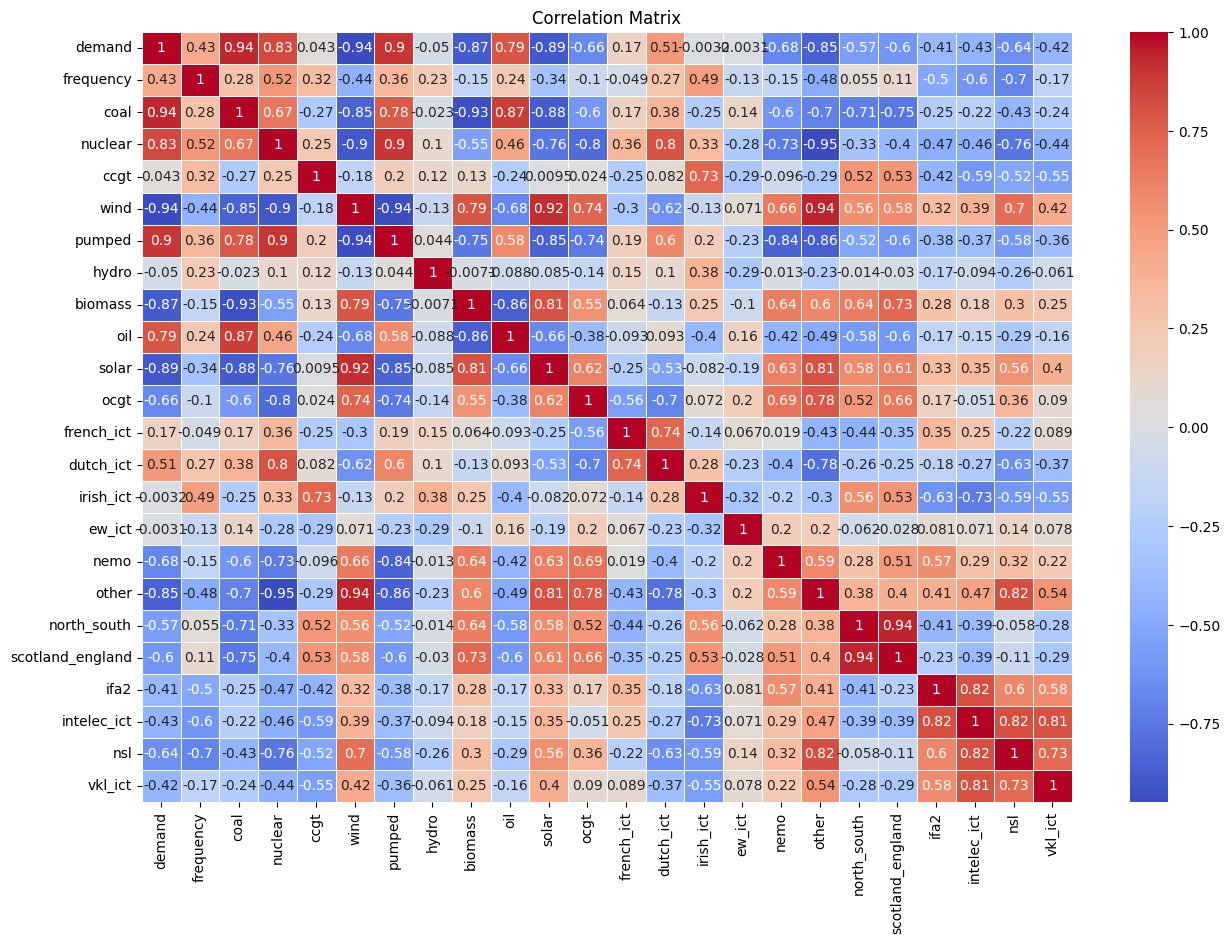

In [17]:
selected_col = [
# ' timestamp', not used
#  'id', not used
 'demand',
 'frequency',
 'coal',
 'nuclear',
 'ccgt',
 'wind',
 'pumped',
 'hydro',
 'biomass',
 'oil',
 'solar',
 'ocgt',
 'french_ict',
 'dutch_ict',
 'irish_ict',
 'ew_ict',
 'nemo',
 'other',
 'north_south',
 'scotland_england',
 'ifa2',
 'intelec_ict',
 'nsl',
 'vkl_ict',
#  'rate', not used
#  'Moving Average' not used
]

df_corr = yearly_data.reset_index()[selected_col]
corr_matrix = df_corr.corr()
# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [18]:
# Top 5 positively correlated
positively_corr=corr_matrix['demand'].sort_values(ascending=False)[1:].head()

# Top 5 negatively correlated
negatively_corr=corr_matrix['demand'].sort_values(ascending=True)[1:].head()

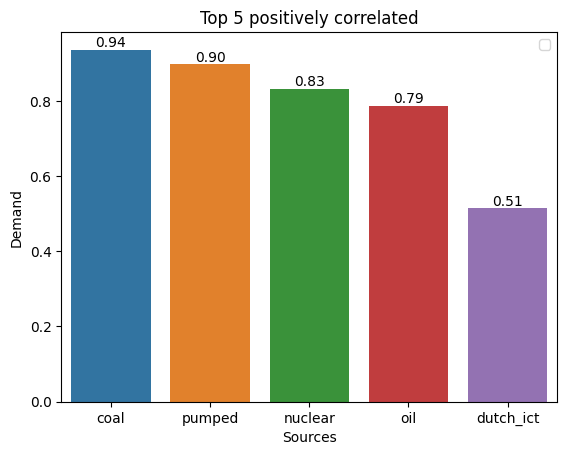

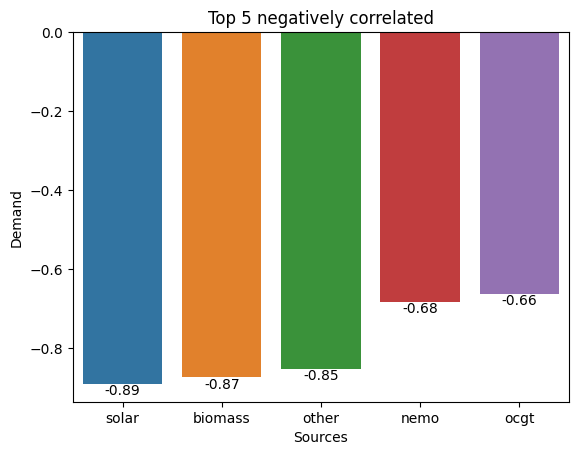

In [19]:
# Bar plot for the same Series
ax = sns.barplot(data=positively_corr.reset_index(), 
           x='index', y='demand')

for i in ax.containers:
    ax.bar_label(i, fmt='%.2f')

plt.title('Top 5 positively correlated')
plt.xlabel('Sources')
plt.ylabel('Demand')
plt.legend()
plt.show()



# Bar plot for the same Series
ax = sns.barplot(data=negatively_corr.reset_index(), 
           x='index', y='demand')

for i in ax.containers:
    ax.bar_label(i, fmt='%.2f')

plt.title('Top 5 negatively correlated')
plt.xlabel('Sources')
plt.ylabel('Demand')
plt.show()



<a id="5-Summary-Reports-and-Insights"></a>
## 5. Summary Reports and Insights

<a id="51-Analyzing"></a>
### 5.1 Analyzing the Daily, Weekly, and Yearly Aggregates Graph

**Understanding the Graph**

The graph you provided depicts the daily, weekly, and yearly aggregates of UK power consumption over time. The blue line represents the daily data, the orange line shows the weekly aggregate, and the green line represents the yearly aggregate. This visualization allows for comparing the trends at different time scales.

**Key Observations**

1. **Seasonal Patterns:** All three lines exhibit clear seasonal variations, with higher demand during the colder months and lower demand during the warmer months.
2. **Smoothing Effect of Aggregates:** As we move from daily to weekly and yearly aggregates, the lines become smoother, indicating that the impact of short-term fluctuations is reduced.
3. **Long-Term Trends:** The yearly aggregate line provides a clear overview of the long-term trend in power consumption. It appears to be generally increasing over the years.
4. **Relationship Between Time Scales:** The relationships between the lines at different time scales can provide insights into the nature of the variations. For example, if the weekly and yearly aggregates closely follow the daily data, it suggests that the seasonal patterns are consistent over time.

**Possible Implications**

* **Energy Planning:** The graph provides valuable information for energy planners and policymakers. Understanding the seasonal patterns and long-term trends can help in forecasting future energy demand and ensuring adequate supply.
* **Renewable Energy Integration:** The increasing demand for power could drive the adoption of renewable energy sources to meet the growing energy needs while reducing carbon emissions.
* **Energy Efficiency Measures:** Identifying periods of peak demand can help in promoting energy efficiency measures to reduce overall consumption and manage load.


<a id="52-Analyzing-Time-Series-Plots"></a>
### 5.2 Analyzing the Time Series Plots

**Understanding the Data:**

The provided image contains three time series plots, each representing the peak and trough demand for different time periods: daily, weekly, and yearly. The blue line shows the demand trend, while the red triangles mark the peak values and the green triangles mark the trough values.

**Key Observations:**

### Daily Peak and Trough Demand:
* **Seasonal Patterns:** The daily plot shows clear seasonal variations, with higher demand during certain months (likely summer or winter) and lower demand during others.
* **Weekly Fluctuations:** Within each week, there are noticeable fluctuations in demand, with peaks likely occurring on weekdays and troughs on weekends.
* **Short-Term Spikes:** The plot also shows occasional short-term spikes in demand, which could be attributed to specific events or factors.

### Weekly Peak and Trough Demand:
* **Seasonal Patterns:** Similar to the daily plot, the weekly plot exhibits seasonal patterns, but the variations are less pronounced.
* **Week-to-Week Fluctuations:** The plot shows week-to-week fluctuations in demand, with some weeks having higher peaks and troughs than others.

### Yearly Peak and Trough Demand:
* **Overall Trend:** The yearly plot reveals an overall decreasing trend in demand over the years. This could be due to factors like energy efficiency improvements, economic conditions, or policy changes.
* **Annual Variations:** While there is a decreasing trend, there are still annual variations in peak and trough demand, likely influenced by seasonal factors and other external influences.


<a id="53-Analyzing-Correlation-Matrix"></a>
### 5.3 Analyzing the Correlation Matrix

**Disclaimer:** While I can provide insights based on the general patterns in the correlation matrix, a more comprehensive analysis would require additional context, such as the specific variables represented and the underlying dataset.

### Key Observations:

1. **Strong Positive Correlations:**
   * **Energy Sources and Demand:** There appears to be a strong positive correlation between energy sources (coal, nuclear, ccgt, wind, pumped, hydro, biomass, oil, solar, ocgt) and demand. This suggests that as demand for energy increases, consumption of these sources also rises.
   * **Renewable Energy Sources:** Within the energy sources, renewable sources like wind, solar, and hydro seem to have a relatively high positive correlation with each other. This might indicate a shared influence or dependence on factors like weather conditions or policy incentives.
2. **Negative Correlations:**
   * **Demand and French ICT:** There's a negative correlation between demand and French ICT. This could suggest that increased energy demand might be associated with decreased activity in the French ICT sector, or vice versa. However, more context is needed to understand the specific relationship.
   * **Coal and Renewable Energy:** Coal appears to have a negative correlation with some renewable energy sources like wind and solar. This might suggest that as the use of renewable energy increases, coal consumption may decrease, potentially due to policy shifts or economic factors.
3. **Clusters of Correlated Variables:**
   * **Energy Sources:** The energy sources themselves seem to form a cluster of highly correlated variables, indicating a strong interrelationship between them.
   * **ICT Sectors:** The ICT-related variables (French ICT, Dutch ICT, Irish ICT, etc.) also appear to form a cluster, suggesting that these sectors are more closely related to each other than to other variables.

### Potential Insights and Further Exploration:

* **Energy Transition:** The correlation between renewable energy sources and demand might suggest a potential shift towards cleaner energy sources as demand increases.
* **Economic Factors:** The negative correlation between demand and French ICT could be influenced by economic factors, such as the relative costs of energy and ICT services or government policies.
* **Sector Interdependencies:** The clustering of variables within energy sources and ICT sectors indicates potential interdependencies or shared drivers within these domains.



<a id="54-Analyzing-the-Bar-Charts"></a>
### 5.4 Analyzing the Bar Charts

**Understanding the Data:**

The bar charts visually represent the top 5 positively and negatively correlated variables with "demand." The height of each bar indicates the strength of the correlation, with positive values representing a positive correlation and negative values representing a negative correlation.

**Key Insights:**

### Top 5 Positively Correlated Variables:

* **Coal:** The strongest positive correlation is with coal, suggesting that as demand increases, coal consumption is also likely to rise. This might be due to traditional energy infrastructure or economic factors.
* **Pumped and Nuclear:** Both pumped and nuclear energy sources show strong positive correlations with demand. This could indicate that these sources play a significant role in meeting energy demand, possibly due to their reliability or baseload capacity.
* **Oil and Dutch ICT:** Oil and Dutch ICT also have positive correlations with demand. This might suggest that increased economic activity, which often drives energy demand, is also associated with increased activity in the oil sector and Dutch ICT.

### Top 5 Negatively Correlated Variables:

* **Solar and Biomass:** The strongest negative correlations are with solar and biomass. This could suggest that as demand increases, the use of solar and biomass might decrease. This could be due to factors like energy mix, policy changes, or economic considerations.
* **Other, Nemo, and OCGT:** The remaining negatively correlated variables (other, nemo, and ocgt) also have relatively strong negative correlations. These might represent less dominant energy sources or sectors that are less directly tied to overall energy demand.

**Further Exploration:**

To gain a deeper understanding of these correlations, it would be helpful to:
* **Identify the variables:** Knowing the exact meanings of "other," "nemo," and "ocgt" would provide more context.
* **Consider the time period:** The correlations might vary over time due to changes in policies, technology, or economic conditions.
* **Analyze additional factors:** Factors like economic growth, population changes, and government incentives could influence these correlations.

By addressing these questions, a more comprehensive analysis can be conducted to draw meaningful conclusions from the bar charts.


<a id="55-Analyzing-the-Daily-Moving-Average-Graph"></a>
### 5.5 Analyzing the Daily Moving Average Graph


**Key Observations**

1. **Seasonal Patterns:** The graph clearly shows seasonal variations in power consumption. The demand tends to be higher during the colder months (likely due to heating) and lower during the warmer months. 
2. **Annual Trends:** There seems to be a general upward trend in power consumption over the years, suggesting increasing energy demand in the UK.
3. **Short-Term Fluctuations:** While the 5-day moving average helps to smooth out short-term noise, there are still noticeable fluctuations, possibly due to factors like weather events, economic activities, or policy changes.
4. **Potential Outliers:** There might be a few data points that deviate significantly from the overall trend, which could be outliers or anomalies that might require further investigation.

**Possible Implications**

* **Energy Planning:** The graph provides valuable insights for energy planners and policymakers. Understanding seasonal patterns and long-term trends can help in forecasting future energy demand and ensuring adequate supply.
* **Renewable Energy Integration:** The increasing demand for power could drive the adoption of renewable energy sources to meet the growing energy needs while reducing carbon emissions.
* **Energy Efficiency Measures:** Identifying periods of peak demand can help in promoting energy efficiency measures to reduce overall consumption and manage load.
